<font size="6"> **Alpha Factor and Quant Research Process** </font>

Run notebook on quant-ai4trading environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import os

import numpy as np
import scipy

from  src import utils
from src.data import read_utils
from src.mle_quant_utils import quant_helper

In [4]:
from zipline.data import bundles
from zipline.utils.calendars import get_calendar
from zipline.pipeline.factors import AverageDollarVolume, Returns, SimpleMovingAverage
from zipline.pipeline import Pipeline
from zipline.data.data_portal import DataPortal

import alphalens as al

In [5]:
cfg = utils.read_conf()

BUNDLE_FOLDER = cfg['quantopian']['dataset1']['bundle_folder']
BUNDLE_NAME = cfg['quantopian']['dataset1']['bundle_name']
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_DATA = cfg['quantopian']['dataset1']['sector_data']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
bundle_path = os.path.join(read_utils.raw_path, 'market_data', BUNDLE_FOLDER)
sector_path = os.path.join(read_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_DATA)
sector_file = os.path.join(read_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)
os.path.isdir(bundle_path)

True

In [9]:
window = int(cfg['models']['universe']['window'])
adv_top = int(cfg['models']['universe']['adv_top'])
univ_start = cfg['models']['universe']['start']

# Create a Zipline Pipieline

## Registering CSV Data Bundle
http://www.zipline.io/bundles.html#ingesting-data-from-csv-files

In [7]:
os.environ['ZIPLINE_ROOT'] = bundle_path
ingest_func = bundles.csvdir.csvdir_equities(['daily'], BUNDLE_NAME)
bundles.register(BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


## Build pipeline engine
* Universe Rule: Rule to select assets in analysis
* Universe end date: 2016
* Universe should avoid several issues, like survivor bias
To create a pandas DF, pipeline engine should be run

In [10]:
universe = AverageDollarVolume(window_length=window).top(adv_top) 
universe_smp = AverageDollarVolume(window_length=window).top(10) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(BUNDLE_NAME)
engine = quant_helper.build_pipeline_engine(bundle_data, trading_calendar)

In [11]:
universe_end_date = pd.Timestamp(univ_start, tz='UTC')
universe_start_date = universe_end_date - pd.DateOffset(years=5)
print(universe_start_date, universe_end_date)

2011-01-05 00:00:00+00:00 2016-01-05 00:00:00+00:00


In [12]:
# 2 years of data is used in factors computation
# Note: Going back 2 years falls on a day when the market is closed. 
# Pipeline package doesn't handle start or end dates that don't fall on days when the market is open.
# To fix this, we went back 2 extra days to fall on the next day when the market is open.
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2) 
print(universe_end_date)

2016-01-05 00:00:00+00:00


In [13]:
# Extract the number of assets at universe_end_date
# running the pipeline creates a pandas DF index with universe stocks
universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()

print('Number of tickers: {}'.format(len(universe_tickers)))
print(universe_tickers[:5])

Number of tickers: 490
[Equity(0 [A]), Equity(1 [AAL]), Equity(2 [AAP]), Equity(3 [AAPL]), Equity(4 [ABBV])]


### Attach prices data to the pipeline using a DataPortal
DataPortal deals with calendar, prices alignment and other issues. DataPortal is used by a pricing function in order to obtain a pandas DF

Returned pandas DF indexed by Date and each stock in the universe is a columns

In [14]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [15]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [16]:
prices_df = get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_start_date,
        universe_end_date)
returns_df = prices_df.pct_change()[1:].fillna(0)  # convert prices into returns

prices_df.head()

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),Equity(10 [ADM]),Equity(11 [ADP]),Equity(12 [ADS]),Equity(13 [ADSK]),Equity(14 [AEE]),Equity(15 [AEP]),Equity(16 [AES]),Equity(17 [AET]),Equity(18 [AFL]),Equity(19 [AGN]),Equity(20 [AIG]),Equity(21 [AIV]),Equity(22 [AIZ]),Equity(23 [AJG]),Equity(24 [AKAM]),...,Equity(465 [WBA]),Equity(466 [WDC]),Equity(467 [WEC]),Equity(468 [WFC]),Equity(469 [WHR]),Equity(471 [WM]),Equity(472 [WMB]),Equity(473 [WMT]),Equity(474 [WRK]),Equity(475 [WU]),Equity(476 [WY]),Equity(477 [WYN]),Equity(478 [WYNN]),Equity(479 [XEC]),Equity(480 [XEL]),Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-06 00:00:00+00:00,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.270,30.936,26.230,34.990,70.301,41.260,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07 00:00:00+00:00,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.040,30.756,26.445,35.070,70.026,40.760,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2011-01-10 00:00:00+00:00,57.255,11.044,61.242,43.507,NaN,30.972,19.831,40.972,32.960,30.846,26.561,35.085,70.606,40.865,20.477,26.378,10.969,29.426,22.846,52.251,44.383,20.128,32.673,22.544,48.79,...,35.570,28.424,22.656,25.550,73.813,28.431,14.186,44.256,NaN,15.210,16.190,25.286,88.950,88.162,17.879,19.028,25.149,59.658,33.599,25.832,NaN,30.604,49.978,22.766,NaN
2011-01-11 00:00:00+00:00,57.147,10.562,60.879,43.404,NaN,31.275,19.790,41.534,32.980,31.116,26.661,35.245,70.832,40.800,20.725,26.496,11.113,29.865,23.074,51.577,45.659,19.547,32.716,22.505,48.75,...,35.466,28.182,22.718,25.714,73.720,28.345,14.541,44.718,NaN,15.386,16.447,25.363,87.743,89.393,17.818,19.053,25.405,60.102,33.846,25.990,NaN,30.406,51.761,22.936,NaN
2011-01-12 00:00:00+00:00,58.133,10.475,61.694,43.757,NaN,31.088,19.770,42.488,33.572,31.124,26.950,35.706,72.386,40.530,20.799,26.519,10.944,29.965,23.683,50.912,45.164,19.794,33.152,22.458,49.26,...,35.787,28.519,22.931,26.214,75.316,28.597,14.839,45.179,NaN,15.314,16.774,25.192,87.511,90.961,17.864,19.148,25.803,60.809,34.766,26.104,NaN,30.486,52.524,22.663,NaN


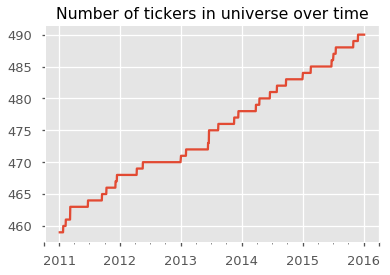

In [17]:
prices_df.notna().sum(axis=1).plot()
plt.title('Number of tickers in universe over time')
plt.show()

In [18]:
print(universe_start_date, universe_end_date)
prices_df.info()

2011-01-05 00:00:00+00:00 2016-01-05 00:00:00+00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2011-01-06 to 2016-01-05
Freq: C
Columns: 490 entries, Equity(0 [A]) to Equity(490 [ZTS])
dtypes: float64(490)
memory usage: 4.7 MB


## Alpha Factor Creation: Add steps to the pipeline

**Create an alpha factor based on momentum: One-year pct return**

$1YearReturn_t = \frac{price_{t} - price_{t-252}}{price_{t-252}}$

Compute the factor in several ways:
* Raw factor: No additional computation added
* Sector de-meaned: Neutralize sector risk (not exposed by overall movements in a sector)
https://www.zipline.io/appendix.html#zipline.pipeline.Factor.demean
* Ranked: Categorize returns in a ranking, reducing noise (relative changes in a portfolio and outliers) 
https://www.zipline.io/appendix.html#zipline.pipeline.factors.Factor.rank
* z-scored: Standardize factor returns in order to ease comparison , combination and evaluation. In addition, make alpha factors comparable after ranking when number of stocks changes (useful to apply rank and then z-score)
https://www.zipline.io/appendix.html#zipline.pipeline.factors.zscore
* smoothing: Decrease noise and missing by compute a moving average over a time window (simple or exponential)
https://www.zipline.io/appendix.html#zipline.pipeline.factors.SimpleMovingAverage
https://www.zipline.io/appendix.html#zipline.pipeline.factors.ExponentialWeightedMovingAverage

### Sector data helper function
The sectors are represented by integers, as sector is needed in demeaning

Inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [19]:
sector = quant_helper.get_sectors(sector_path)
print(len(sector.data), np.unique(sector.data))

491 [-1  0  1  2  3  4  5  6  7  8  9 10]


In [20]:
## Sector Labels
sector_names = pd.read_csv(sector_file)
sector_names = sector_names[['Sector','sector_id']]
sector_names = sector_names.drop_duplicates()
sector_names = sector_names.append(pd.DataFrame([['no sector assigned',-1]], columns = sector_names.columns))
sector_names

,Sector,sector_id
0,Healthcare,0
1,Technology,1
2,Consumer Defensive,2
3,Industrials,3
4,Utilities,4
5,Financial Services,5
6,Real Estate,6
7,Communication Services,7
8,Consumer Cyclical,8
9,Energy,9


In [21]:
# raw factors
rets_1d_raw = (
    Returns(window_length=2, mask=universe)
)
rets_1d_demean = (
    Returns(window_length=2, mask=universe).demean(groupby=sector)
)
rets_1y_raw = (
    Returns(window_length=252, mask=universe)
)
# sector demean, rank and z-score
rets_1y = (
    Returns(window_length=252, mask=universe).
    demean(groupby=sector). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)
# factor smoothing
rets_1y_smooth = (
    SimpleMovingAverage(inputs=[rets_1y], window_length=5)
)

In [22]:
# create a pipeline called
p = Pipeline(screen=universe)

# add the factors to the pipeline
p.add(sector, 'sector_code')
p.add(rets_1d_raw, 'rets_1d_raw')
p.add(rets_1y_raw, 'rets_1y_raw')
p.add(rets_1y, 'Momentum_1YR')  # demeaned, ranked, zscored
p.add(rets_1y_smooth, 'Smoothed_Momentum_1YR') # demeaned, ranked, zscored and smoothed

In [23]:
# Run the pipeline to obtain a factor returns pandas DF
factors_df = engine.run_pipeline(p, factor_start_date, universe_end_date)
factors_df.head()

Momentum_1YR  \
2014-01-03 00:00:00+00:00 Equity(0 [A])         1.499391   
                          Equity(1 [AAL])       1.602797   
                          Equity(2 [AAP])       0.376694   
                          Equity(3 [AAPL])     -1.484618   
                          Equity(4 [ABBV])      0.915884   

                                            Smoothed_Momentum_1YR  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                  1.484295   
                          Equity(1 [AAL])                1.564182   
                          Equity(2 [AAP])                0.231375   
                          Equity(3 [AAPL])              -1.475412   
                          Equity(4 [ABBV])               0.919577   

                                            rets_1d_raw  rets_1y_raw  \
2014-01-03 00:00:00+00:00 Equity(0 [A])        0.001321     0.799433   
                          Equity(1 [AAL])      0.004360     0.856600   
                          Equity(2 [AAP])     -0.008497     0.518050   
                          Equity(3 [AAPL])    -0.014053     0.045903   
                          Equity(4 [ABBV])    -0.015713     0.551403   

                                            sector_code  
2014-01-03 00:00:00+00:00 Equity(0 [A])               0  
                          Equity(1 [AAL])             3  
                          Equity(2 [AAP])             8  
                          Equity(3 [AAPL])            1  
                          Equity(4 [ABBV])            0

### Checking results and manual replication

In [24]:
p_smp = Pipeline(screen=universe_smp)

rets_1d_smp_raw = (
    Returns(window_length=2, mask=universe_smp)
)
rets_1d_smp_demean = (
    Returns(window_length=2, mask=universe_smp).demean(groupby=sector)
)
rets_1d_smp_demean_rank = (
    Returns(window_length=2, mask=universe_smp).demean(groupby=sector).rank()
)
rets_1d_smp_demean_rank_zscore = (
    Returns(window_length=2, mask=universe_smp).demean(groupby=sector).rank().zscore()
)
rets_1d_smp_demean_rank_zscore_smooth = (
    SimpleMovingAverage(inputs=[rets_1d_smp_demean_rank_zscore], window_length=5)
)
p_smp.add(sector, 'sector_code')
p_smp.add(rets_1d_smp_raw, 'rets_1d_raw')
p_smp.add(rets_1d_smp_demean, 'rets_1d_demean')
p_smp.add(rets_1d_smp_demean_rank, 'rets_1d_demean_rank')
p_smp.add(rets_1d_smp_demean_rank_zscore, 'rets_1d_demean_rank_zscore')
p_smp.add(rets_1d_smp_demean_rank_zscore_smooth, 'rets_1d_demean_rank_zscore_smooth')
factors_smp_df = engine.run_pipeline(p_smp, factor_start_date, universe_end_date)

factors_smp_df[:2]

rets_1d_demean  \
2014-01-03 00:00:00+00:00 Equity(3 [AAPL])        -0.007452   
                          Equity(38 [AMZN])        0.006235   

                                             rets_1d_demean_rank  \
2014-01-03 00:00:00+00:00 Equity(3 [AAPL])                   3.0   
                          Equity(38 [AMZN])                  8.0   

                                             rets_1d_demean_rank_zscore  \
2014-01-03 00:00:00+00:00 Equity(3 [AAPL])                    -0.870388   
                          Equity(38 [AMZN])                    0.870388   

                                             rets_1d_demean_rank_zscore_smooth  \
2014-01-03 00:00:00+00:00 Equity(3 [AAPL])                           -0.104447   
                          Equity(38 [AMZN])                           0.522233   

                                             rets_1d_raw  sector_code  
2014-01-03 00:00:00+00:00 Equity(3 [AAPL])     -0.014053            1  
                          Equity(38 [AMZN])    -0.002056            8

#### Sector Demeaning

In [25]:
asset_idx = factors_smp_df.index.get_level_values(1)[0]
sector_idx = factors_smp_df.loc[(factor_start_date, asset_idx), 'sector_code']

factors_smp_df.loc[(factor_start_date, asset_idx), :]

rets_1d_demean                      -0.007452
rets_1d_demean_rank                  3.000000
rets_1d_demean_rank_zscore          -0.870388
rets_1d_demean_rank_zscore_smooth   -0.104447
rets_1d_raw                         -0.014053
sector_code                          1.000000
Name: (2014-01-03 00:00:00+00:00, Equity(3 [AAPL])), dtype: float64

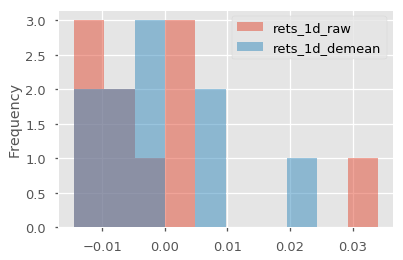

In [26]:
factors_smp_df.xs(level=0, key=factor_start_date)[['rets_1d_raw', 'rets_1d_demean']].plot.hist(alpha=0.5)
plt.show()

In [27]:
factors_smp_df.xs(level=0, key=factor_start_date)[['rets_1d_raw', 'rets_1d_demean']].describe().T

,count,mean,std,min,25%,50%,75%,max
rets_1d_raw,10.0,-1.831434e-03,0.014329,-0.014526,-0.012233,-0.004376,0.001697,0.034032
rets_1d_demean,10.0,-1.040834e-18,0.009758,-0.011112,-0.007148,-0.000133,0.004676,0.021030


In [28]:
day_grp_idx = factors_smp_df.index.get_level_values(0)
sector_grp_idx = factors_smp_df['sector_code']

sector_returns_dlymean = factors_smp_df.groupby([day_grp_idx, sector_grp_idx])['rets_1d_raw'].mean()
sector_returns_dlymean[:3]

                           sector_code
2014-01-03 00:00:00+00:00  1             -0.006601
                           5              0.013002
                           8             -0.008291
Name: rets_1d_raw, dtype: float64

In [29]:
asset_ret = factors_smp_df.loc[(factor_start_date, asset_idx), 'rets_1d_raw']
asset_ret

-0.014053174172544782

In [30]:
sector_ret = sector_returns_dlymean[(factor_start_date, int(sector_idx))]
sector_ret

-0.006601214337735402

In [31]:
asset_ret-sector_ret

-0.00745195983480938

In [32]:
factors_smp_df.loc[(factor_start_date, asset_idx), ['rets_1d_raw', 'rets_1d_demean']]

rets_1d_raw      -0.014053
rets_1d_demean   -0.007452
Name: (2014-01-03 00:00:00+00:00, Equity(3 [AAPL])), dtype: float64

#### Ranking

In [33]:
factors_smp_df.xs(level=0, key=factor_start_date)[['rets_1d_raw', 'rets_1d_demean', 'rets_1d_demean_rank']]

,rets_1d_raw,rets_1d_demean,rets_1d_demean_rank
Equity(3 [AAPL]),-0.014053,-0.007452,3.0
Equity(38 [AMZN]),-0.002056,0.006235,8.0
Equity(59 [BAC]),0.034032,0.021030,10.0
Equity(74 [C]),0.003085,-0.009918,2.0
Equity(173 [FB]),0.001116,0.007717,9.0
Equity(199 [GOOGL]),-0.006773,-0.000172,5.0
Equity(253 [JPM]),0.001890,-0.011112,1.0
Equity(312 [MSFT]),-0.006695,-0.000094,6.0
Equity(323 [NFLX]),-0.014526,-0.006235,4.0
Equity(483 [XOM]),-0.014334,0.000000,7.0


In [34]:
ranks = scipy.stats.rankdata(factors_smp_df.xs(level=0, key=factor_start_date)['rets_1d_demean'].values)
ranks

array([ 3.,  8., 10.,  2.,  9.,  5.,  1.,  6.,  4.,  7.])

#### z-score

In [35]:
factors_smp_df.xs(level=0, key=factor_start_date)[['rets_1d_raw', 'rets_1d_demean', 'rets_1d_demean_rank', 'rets_1d_demean_rank_zscore']]

,rets_1d_raw,rets_1d_demean,rets_1d_demean_rank,rets_1d_demean_rank_zscore
Equity(3 [AAPL]),-0.014053,-0.007452,3.0,-0.870388
Equity(38 [AMZN]),-0.002056,0.006235,8.0,0.870388
Equity(59 [BAC]),0.034032,0.021030,10.0,1.566699
Equity(74 [C]),0.003085,-0.009918,2.0,-1.218544
Equity(173 [FB]),0.001116,0.007717,9.0,1.218544
Equity(199 [GOOGL]),-0.006773,-0.000172,5.0,-0.174078
Equity(253 [JPM]),0.001890,-0.011112,1.0,-1.566699
Equity(312 [MSFT]),-0.006695,-0.000094,6.0,0.174078
Equity(323 [NFLX]),-0.014526,-0.006235,4.0,-0.522233
Equity(483 [XOM]),-0.014334,0.000000,7.0,0.522233


In [36]:
mu = ranks.mean()
sigma =ranks.std()
zscore = (ranks-mu)/sigma
zscore

array([-0.87038828,  0.87038828,  1.5666989 , -1.21854359,  1.21854359,
       -0.17407766, -1.5666989 ,  0.17407766, -0.52223297,  0.52223297])

In [37]:
# binning will produce a normal distribution, whereas ranking will yield a uniform one
bins = factors_smp_df.groupby(level=0)['rets_1d_demean'].apply(
    lambda grp: pd.cut(grp, bins=np.linspace(start=grp.min(), stop=grp.max(), num=99), labels=False, include_lowest=True))
mu = bins.groupby(level=0).transform(np.mean)
std = bins.groupby(level=0).transform(np.std)
bins_zscore = (bins - mu)/std

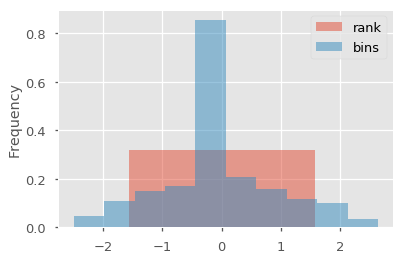

In [38]:
ax = factors_smp_df.xs(level=0, key=factor_start_date)['rets_1d_demean_rank_zscore'].plot.hist(density=True, alpha=0.5, label='rank')
bins_zscore.plot.hist(ax=ax, density=True, alpha=0.5, label='bins')
plt.legend()
plt.show()

#### smoothing

In [39]:
smooth_day = factors_smp_df.xs(level=1, key=asset_idx).rolling(5)['rets_1d_demean_rank_zscore'].mean().iloc[4:5]
smooth_day

2014-01-09 00:00:00+00:00   -0.661495
Name: rets_1d_demean_rank_zscore, dtype: float64

In [40]:
factors_smp_df.loc[(smooth_day.index[0], asset_idx), 'rets_1d_demean_rank_zscore_smooth']

-0.6614950926316518

In [41]:
print(factor_start_date, universe_end_date)
factors_df.info()

2014-01-03 00:00:00+00:00 2016-01-05 00:00:00+00:00
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 244259 entries, (2014-01-03 00:00:00+00:00, Equity(0 [A])) to (2016-01-05 00:00:00+00:00, Equity(490 [ZTS]))
Data columns (total 5 columns):
Momentum_1YR             239517 non-null float64
Smoothed_Momentum_1YR    239517 non-null float64
rets_1d_raw              244247 non-null float64
rets_1y_raw              241113 non-null float64
sector_code              244259 non-null int64
dtypes: float64(4), int64(1)
memory usage: 10.3+ MB


#### Verify factor computation: 1d returns

In [42]:
ticker = prices_df.columns[0]
dates = list(pd.date_range('2014-01-03', '2014-01-07'))

In [43]:
factors_df.loc[(dates, ticker) , 'rets_1d_raw']

2014-01-03 00:00:00+00:00  Equity(0 [A])    0.001321
2014-01-06 00:00:00+00:00  Equity(0 [A])    0.006951
2014-01-07 00:00:00+00:00  Equity(0 [A])    0.005740
Name: rets_1d_raw, dtype: float64

In [44]:
prices_df[ticker].pct_change(1)['2014-01-01': '2014-01-06']

2014-01-02 00:00:00+00:00    0.001321
2014-01-03 00:00:00+00:00    0.006951
2014-01-06 00:00:00+00:00    0.005740
Freq: C, Name: Equity(0 [A]), dtype: float64

#### Check number of stocks in universe

In [45]:
# get list of stocks in our portfolio (tickers that identify each stock)
assets = factors_df.index.levels[1].values.tolist()
print("stock universe number of stocks {}, and number of stocks for which we have factor values {}".format(len(universe_tickers), len(assets)))

stock universe number of stocks 490, and number of stocks for which we have factor values 490


#### Compare to the factor data for a single stock

In [46]:
stock_index_name = factors_df.index.get_level_values(1)[3] #just pick a stock; in this case, stock number 3 is AAPL
single_stock_factor_df = factors_df[np.in1d(factors_df.index.get_level_values(1), [stock_index_name])]

In [47]:
pd.concat([single_stock_factor_df.head(2), single_stock_factor_df.tail(2)], axis=0)

,,Momentum_1YR,Smoothed_Momentum_1YR,rets_1d_raw,rets_1y_raw,sector_code
2014-01-03 00:00:00+00:00,Equity(3 [AAPL]),-1.484618,-1.475412,-0.014053,0.045903,1
2014-01-06 00:00:00+00:00,Equity(3 [AAPL]),-1.469846,-1.482926,-0.021972,0.052237,1
2016-01-04 00:00:00+00:00,Equity(3 [AAPL]),-0.494357,-0.541467,-0.019199,-0.020871,1
2016-01-05 00:00:00+00:00,Equity(3 [AAPL]),-0.306718,-0.495778,0.000855,0.008378,1


In [48]:
single_stock_factor_df.shape

(505, 5)

# Factor Cleaning and  Alignment in Alphalens

First of all, forward returns must be computed and then use a evaluation technique that rely on that forward returns. To achieve that, alphalens functionalities provides easy calculation, data alignment etc.

## Prepare data for use in alphalens: alpha factor and forward returns

$$r^{forward}_{t} = r_{t+\tau} - r_{t}$$

Alphalens makes sure the data is formatted properly so that other neat alphalens functions can work with the data.
For instance, it lines up the price data and factor data and calculates forward returns that are associated with each factor value.
We'll use [alphalens.utils.get_clean_factor_and_forward_returns](https://github.com/quantopian/alphalens/blob/master/alphalens/utils.py)

The source code describes what it's used for (I'm showing just the parameters that we'll use here):
```python
def get_clean_factor_and_forward_returns(factor,
                                         prices,
                                         ...
                                         periods=(1, 5, 10),
                                         ...
                                         ):

...
```
  
* The factor is the (MultiIndex) Series containing the alpha-factor scores or raw values
* The prices are the Series of prices for each stock on each date (the same dates as for the factor).  Note that if the period we give is greater than 1, we'll want to make sure to pad our price data by the period amount so that forward returns can be calculated.  Keep reading for details about "periods" parameter.
* periods: this is the period for which we'll compute forward returns.  For instance, if prices and factor data have one data point per day (daily data), and if we wish to calculate the return of our factor-weighted portfolio every day, then the period would be 1, and input as a list [1].  If we wanted to calculate the weekly return, we would input [5].  If we wanted both daily and weekly, we could input [1,5].

returns: multi-index Pandas dataframe containing the cleaned version of the data.
* The 1D column represents the forward returns. 
* factor is the factor value or scores
* factor_quantile is automatically added by alphalens

In [49]:
# forward returns underlying data
pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets, #notice that we used assets instead of universe_tickers; in this example, they're the same
        factor_start_date, # notice we're using the same start and end dates for when we calculated the factor
        universe_end_date)

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
factor_names = factors_df.columns
print("The factor names are {}".format(factor_names))

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=factors_df[factor_name],  # Select column from factor data
        prices=pricing,  # prices to compute forward returns
        periods=[1])  #1day forward returns

The factor names are Index(['Momentum_1YR', 'Smoothed_Momentum_1YR', 'rets_1d_raw', 'rets_1y_raw',
       'sector_code'],
      dtype='object')
Formatting factor data for: Momentum_1YR
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Smoothed_Momentum_1YR
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: rets_1d_raw
Dropped 0.6% entries from factor data: 0.4% in forward returns computation and 0.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: rets_1y_raw
Dropped 1.7% entries from factor data: 1.7% in forward returns computation and 0.0% in binning

## Verify the cleaned data

In [51]:
factor_names

Index(['Momentum_1YR', 'Smoothed_Momentum_1YR', 'rets_1d_raw', 'rets_1y_raw',
       'sector_code'],
      dtype='object')

In [52]:
factor_data[factor_names[0]]
pd.concat([factor_data[factor_names[0]].head(2), factor_data[factor_names[0]].tail(2)], axis=0)

1D    factor  \
date                      asset                                    
2014-01-06 00:00:00+00:00 Equity(0 [A])       0.015168  1.521549   
                          Equity(1 [AAL])    -0.004649  1.573252   
2016-01-04 00:00:00+00:00 Equity(489 [ZION]) -0.010853 -0.212898   
                          Equity(490 [ZTS])   0.015647  0.227332   

                                              factor_quantile  
date                      asset                                
2014-01-06 00:00:00+00:00 Equity(0 [A])                     5  
                          Equity(1 [AAL])                   5  
2016-01-04 00:00:00+00:00 Equity(489 [ZION])                3  
                          Equity(490 [ZTS])                 3

In [53]:
factor_data[factor_names[0]].loc['2014-01-06'].describe().T

,count,mean,std,min,25%,50%,75%,max
1D,469.0,7.378099e-03,0.012065,-0.055814,0.001236,0.006762,0.012448,0.096734
factor,469.0,9.468853e-18,1.001068,-1.728362,-0.864181,0.000000,0.864181,1.728362
factor_quantile,469.0,3.000000e+00,1.417232,1.000000,2.000000,3.000000,4.000000,5.000000


In [54]:
factor_data[factor_names[0]].index.get_level_values(1)[3]

Equity(3 [AAPL])

In [55]:
single_stock_factor_df.index.get_level_values(1)[3]

Equity(3 [AAPL])

In [56]:
factor_data[factor_names[0]].loc[('2014-01-06', factor_data[factor_names[0]].index.get_level_values(1)[3])]

1D                -0.007163
factor            -1.469846
factor_quantile    1.000000
Name: (2014-01-06 00:00:00+00:00, Equity(3 [AAPL])), dtype: float64

In [57]:
single_stock_factor_df.loc[('2014-01-06', single_stock_factor_df.index.get_level_values(1)[3]), factor_names[0:1]]

,,Momentum_1YR
2014-01-06 00:00:00+00:00,Equity(3 [AAPL]),-1.469846
